In [1]:
# importing required packages

from tensorflow.keras.applications import EfficientNetB0 as enet
from tensorflow.keras import models
from tensorflow.keras import layers
import tensorflow.keras as keras
import tensorflow as tf
import numpy as np

from PIL import Image, ImageDraw

In [2]:
# loading pretrained model, setting input shape
inputs = (224, 224, 3)

# Selecting a topless model (sounds damn good...)
basemodel = enet(include_top=False, input_shape=inputs, weights="imagenet")

# locking the trained weights (freezing?)
basemodel.trainable = False 

# checking out how its like
basemodel.summary()

e_expand[0][0]          
__________________________________________________________________________________________________
block5b_project_conv (Conv2D)   (None, 14, 14, 112)  75264       block5b_se_excite[0][0]          
__________________________________________________________________________________________________
block5b_project_bn (BatchNormal (None, 14, 14, 112)  448         block5b_project_conv[0][0]       
__________________________________________________________________________________________________
block5b_drop (Dropout)          (None, 14, 14, 112)  0           block5b_project_bn[0][0]         
__________________________________________________________________________________________________
block5b_add (Add)               (None, 14, 14, 112)  0           block5b_drop[0][0]               
                                                                 block5a_project_bn[0][0]         
____________________________________________________________________________________

In [3]:
# to rebuild top layer for our own classification

dropout_rate = 0.1 #i_dunno_yet - supposed to prevent overfit
types = 2 #currently only mask and no mask 

# building up the model in sequence
model = models.Sequential()

# loading the original topless model
model.add(basemodel)

# adding global pooling 2d to remove the columns and rows output from previous layer
model.add(layers.GlobalMaxPooling2D(name="gap"))

# adding the dropout and subsequently the softmax layer
model.add(layers.Dropout(dropout_rate, name="drout"))
model.add(layers.Dense(types, activation="softmax", name="classdense"))

# view the assembled model
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 7, 7, 1280)        4049571   
_________________________________________________________________
gap (GlobalMaxPooling2D)     (None, 1280)              0         
_________________________________________________________________
drout (Dropout)              (None, 1280)              0         
_________________________________________________________________
classdense (Dense)           (None, 2)                 2562      
Total params: 4,052,133
Trainable params: 2,562
Non-trainable params: 4,049,571
_________________________________________________________________


In [4]:
def get_list(whole_list, unique, filter, list_pos):

    ret_list = []
    dsize = len(whole_list)
    
    # handle use cases
    if list_pos == 0 or list_pos > 2:
        print("Invalid parameter call - return NULL")
        return    # not needed - do nothing
    elif list_pos == 1:    # extract directories
         for record in range(0,dsize):
            item = whole_list[record][list_pos]   # list item to extract [depth,path,filename]
            if unique:   # process unique paths
                if item not in ret_list:   # check if already added
                    ret_list.append(item)
            else:
                ret_list.append(item)
    elif list_pos == 2:    # extract filenames
        for record in range(0,dsize):
            item = whole_list[record][list_pos]   # list item to extract [depth,path,filename]
            if whole_list[record][1] == filter:
                ret_list.append(item)   
    
    return ret_list

In [5]:
# todo - image preprocessing function (to check)

def make_tf_dataset(all_files):
    type_names = []
    tf_img_array = []

    dirlist = get_list(all_files, True, "*", 1)   # get unique directories
    
    for folder in dirlist:
        for pic in os.listdir(folder):
            image = os.path.join(folder, pic)
            image = tf.io.read_file(image)
            image = tf.io.decode_image(image, channels = 3, expand_animations = False)
            image = tf.image.resize(image, (224, 224))
            image = tf.cast(image / 255, tf.float32)
            tf_img_array.append(image)
            type_names.append(folder)
    
    type_dict = {k : v for v, k in enumerate(np.unique(type_names))}
    target_class= [type_dict[type_names[i]] for i in range(len(type_names))]
    tf_y = tf.cast(list(map(int, target_class)), tf.int32)

    #debug - print(f"dict = {type_dict}\n targetclass = {target_class}\n y= {tf_y}")
    return tf.stack(tf_img_array, axis = 0), tf_y

In [6]:
import os
# from itertools import groupby
# from operator import itemgetter

# You traverse the tree twice. Not really necessary. The code essentially creates a list of tuples. 
# Each tuple contains the depth, the relative path, and the filename.
# After that the list is sorted to have the deepest folder(s) first.
# Following that the code groups the files by depth and relative path. 
# it is using the groupby method of the itertools method.

def get_deepest_folders(path):

    a_files = []

    for root, dirs, files in os.walk(path):
        for file in files:
            # print("Looking at", file)
            relativePath = os.path.relpath(root, path)
            # print("In relative path", relativePath, root, path)
            if relativePath == ".":
                relativePath = ""
            a_files.append(
                (root.count(os.path.sep),
                root,
                file
                )
            )
    return a_files

In [7]:
def show_sample(whole_list, sampling = 0):

    # Code to display sample of the images
    if sampling <=0:
        return   # do nothing

    dirlist = get_list(whole_list, True, "*", 1)   # get directories

    foldersize = len(dirlist)
    print("There are: ", foldersize, " folders to be processed.")

    for directory in dirlist:
        print("Current directory: ", directory, "\r")
        filenames = get_list(whole_list, False, directory, 2)   # get all filenames
        
        for i in range (0,sampling): 
            pil_im = Image.open(directory + "/" + filenames[i])
            display(pil_im)
            print(filenames[i])  
    return

In [8]:
cwd = os.getcwd()
print(cwd)

/Users/majordomo/Documents/GitHub/AI-0403-Team-3/notebook


There are:  2  folders to be processed.
Current directory:  ../data/training/WithoutMask 


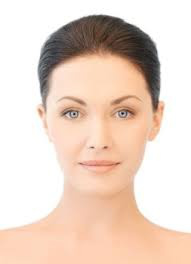

63.jpg


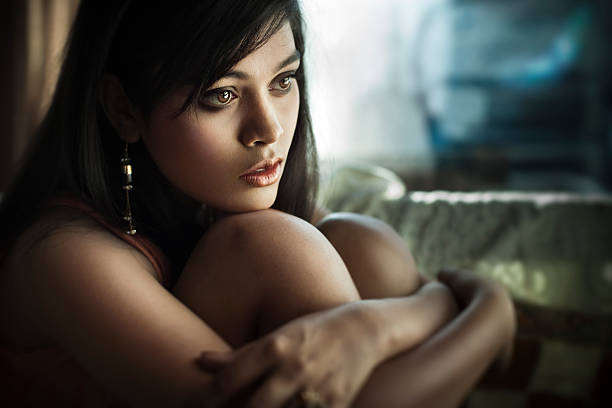

823.jpg


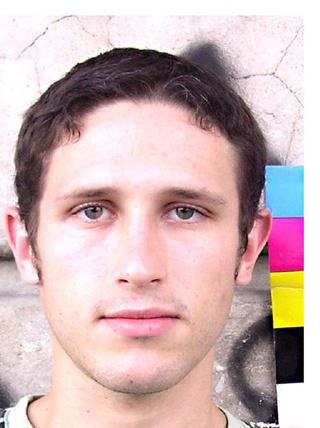

augmented_image_19.jpg
Current directory:  ../data/training/WithMask 


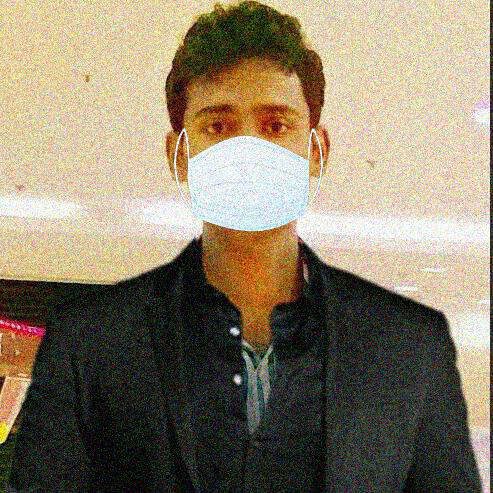

augmented_image_218.jpg


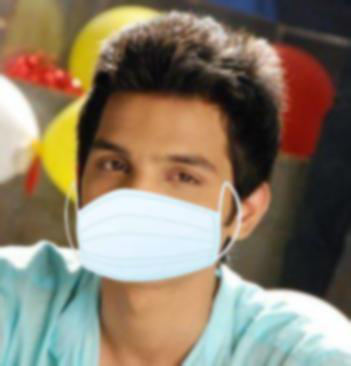

augmented_image_19.jpg


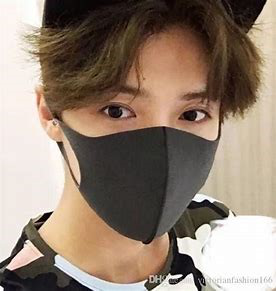

814-with-mmask.jpg


In [9]:
# setting image folder
base_dir = '../data'
train_dir = os.path.join(base_dir, 'training')
validation_dir = os.path.join(base_dir, 'validation')

media_folder = train_dir

all_files = get_deepest_folders(media_folder)

# display sample images from all subdirectories
show_sample(all_files, 3) 
 
# executing the create image function, returns two 


tf_img_array, tf_y = make_tf_dataset(all_files)

In [10]:
tf_img_array

<tf.Tensor: shape=(2168, 224, 224, 3), dtype=float32, numpy=
array([[[[1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         ...,
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ]],

        [[1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         ...,
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ]],

        [[1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         ...,
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ]],

        ...,

        [[1.        , 0.8549019

In [11]:
tf_y

<tf.Tensor: shape=(2168,), dtype=int32, numpy=array([1, 1, 1, ..., 0, 0, 0], dtype=int32)>

In [12]:
# to compile the model (specifying optimser, loss and metrics) - I_dunno_need_adj_later

model.compile(optimizer=keras.optimizers.Adadelta(learning_rate=0.001, rho=0.95, epsilon=1e-07),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()]
    )


# fitting the processed images into the model

batch_size = 32
epochs_to_run = 20

print("Fit model on training data:")
history = model.fit(tf_img_array, tf_y, batch_size = batch_size, epochs = epochs_to_run)

Fit model on training data:
Epoch 1/20
68/68 [==============================] - 144s 2s/step - loss: 4.2659 - sparse_categorical_accuracy: 0.5257
Epoch 2/20
68/68 [==============================] - 125s 2s/step - loss: 3.9808 - sparse_categorical_accuracy: 0.5112
Epoch 3/20
68/68 [==============================] - 122s 2s/step - loss: 3.2227 - sparse_categorical_accuracy: 0.5222
Epoch 4/20
68/68 [==============================] - 122s 2s/step - loss: 2.9322 - sparse_categorical_accuracy: 0.4987
Epoch 5/20
68/68 [==============================] - 127s 2s/step - loss: 2.4880 - sparse_categorical_accuracy: 0.5214
Epoch 6/20
68/68 [==============================] - 122s 2s/step - loss: 1.9213 - sparse_categorical_accuracy: 0.5365
Epoch 7/20
68/68 [==============================] - 124s 2s/step - loss: 1.7257 - sparse_categorical_accuracy: 0.5014
Epoch 8/20
68/68 [==============================] - 121s 2s/step - loss: 1.6387 - sparse_categorical_accuracy: 0.4832
Epoch 9/20
68/68 [==========